# Fair K-center: Bias measuring and mitigation in clustering tasks

The bias problem can appear in models when the predictions systematically deviate from the true values for certain subgroups in the dataset. This phenomenon can occur due to various reasons such as unbalanced groups in the training data, feature selection, or model specification. Because of this, the bias problem can appear in different tasks, being "clustering task" one of them. 

There are various techniques to measure bias in clustering tasks. One common approach is to use fairness metrics such as Fair K-Center Clustering, Fair K-Median Clustering, Fairlet Clustering, Variational Fair Clustering etc.

Once bias is detected, we can employ different techniques to mitigate it. These methods can be grouped into three categories: Pre-processing, in-processing and post-processing methods. Pre-processing techniques are used to adjust the training data to remove bias, while in-processing methods are applied to build robust models against bias. Finally, post-processing techniques are used to adjust the model's predictions to remove bias.

Through this tutorial, we pretend to present you tools which can be easily applied to measure and mitigate the presence of bias in clustering models.

We will follow the traditional outline for this tutorial:

1. Data tasks: loading, exploration and preprocessing 
2. Train Baseline
3. Train Model with Mitigator
4. Using Pipeline
5. Results comparison

## **1. Data tasks: loading, exploration and preprocessing**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai
```

### **1.1 Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')

### **1.2 Data Exploration**

The dataset that we will use is the "Heart Failure Clinical Records" dataset which is a publicly available dataset that contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features. The objective is to predict if the patient deceased during the follow-up period.

Source: [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records)

In [4]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


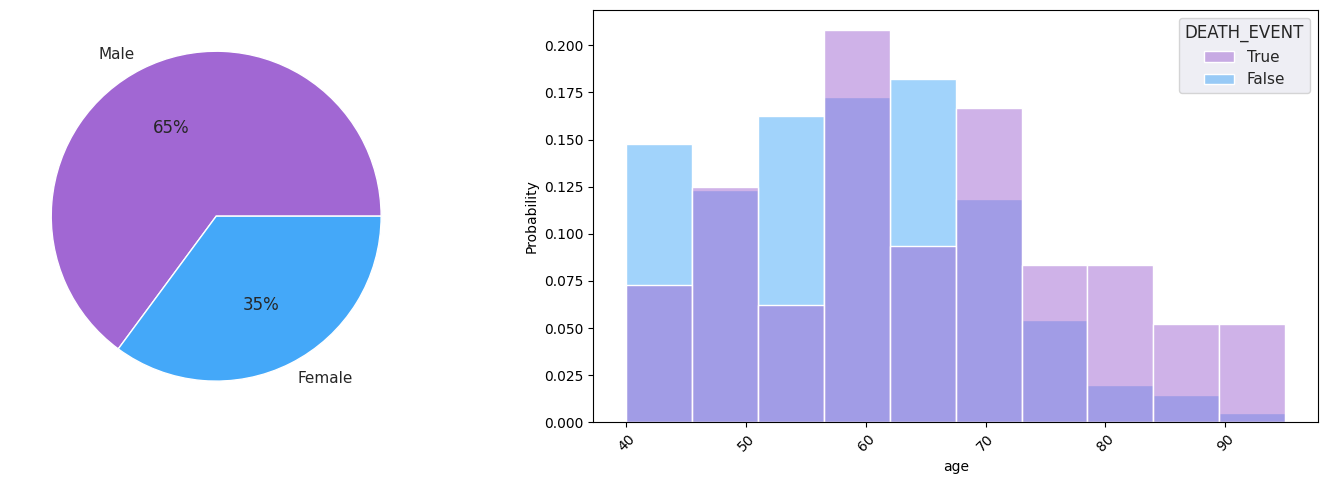

In [6]:
from holisticai.bias.plots import group_pie_plot, histogram_plot

fig, axes = plt.subplots(nrows = 1, ncols =2, figsize=(15,5))
group_pie_plot(df['sex'].replace({1:'Male', 0:'Female'}), ax = axes[0])
histogram_plot(df['age'], df['DEATH_EVENT'].replace({1:'True', 0:'False'}), ax = axes[1])
plt.tight_layout()

The previous graphs show us that the proportion of male is high compared to the female.

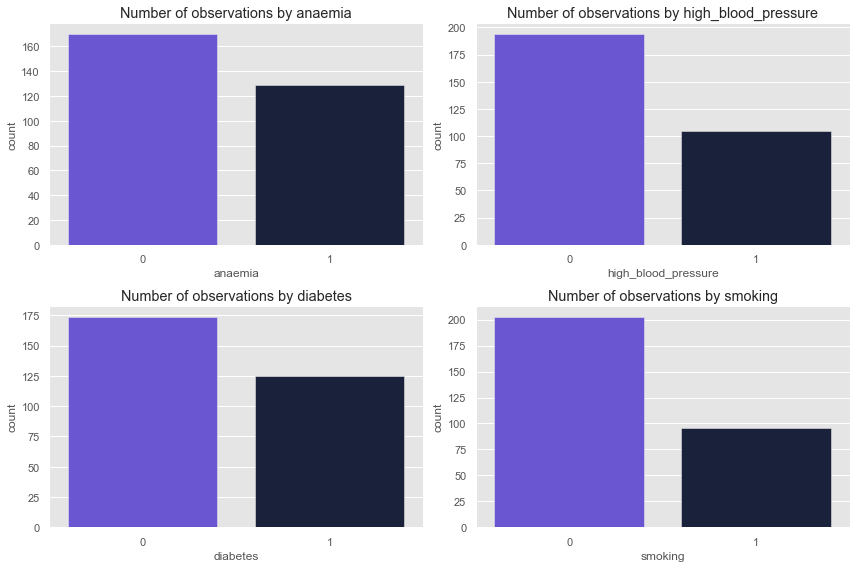

In [45]:
colors = ["#5b42e4", "#141e41"]
plt.style.use('ggplot')
haiPallete = sns.set_palette(sns.color_palette(colors))

fig, axes = plt.subplots(ncols=2, nrows= 2, figsize=(12,8))
cols = ['anaemia', 'high_blood_pressure','diabetes','smoking']
for i, ax in zip(cols, axes.flat):
    sns.countplot(x=i, data=df, ax = ax, palette=haiPallete).set_title(f'Number of observations by {i}')
    plt.tight_layout()

### **1.3 Pre-processing**

Now, we need to preprocess the dataset before to feed it into the model. To perform this step we will define a function that will clean the dataset and will separate the protected groups according a given feature:

In [8]:
def preprocessing_clustering(df, target_feature, protected_feature):
    """Performs the pre-processing step of the df."""
    # Remove NaN elements from dataframe
    df_ = df.copy()
    df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
    df_clean = df_clean.dropna()
    # Get the protected attribute vectors
    group_a = df[protected_feature] == 0
    group_b = df[protected_feature] == 1

    group_a = np.squeeze(group_a.values)
    group_b = np.squeeze(group_b.values)

    # Remove unnecessary columns

    df_clean["class"] = df_clean[target_feature]
    tmp = df_clean.drop(columns=["sex", "age", target_feature])
    df_clean = pd.concat([tmp, df_clean["class"].astype("uint8")], axis=1)

    return df_clean, group_a, group_b

In [9]:
df_clean, group_a, group_b = preprocessing_clustering(df, target_feature='DEATH_EVENT', protected_feature='sex')

In [10]:
df.shape, df_clean.shape

((299, 13), (299, 12))

In [11]:
X = df_clean.iloc[:,:-1].values
y = df_clean.iloc[:,-1].values

X.shape, y.shape

((299, 11), (299,))

## **2. Train Baseline**

Once we have defined the input and output sets, we can train a model as usual. Since the protected groups were separated from the dataset previously we do not need to take care of that in this opportunity, but do not forget to separate the protected attributes from the dataset, so that the model does not have any influence from these attributes in its training process. 

To train our baseline, we will use a traditional pipeline, we will fit and re-scale the training data, and then we will use the data to train a "K-means" model and once the model has been trained, we can use its predictions to calculate the fairness metrics of the it.

In [12]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from holisticai.pipeline import Pipeline

In [13]:
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
        train_test_split(X, y, group_a, group_b, test_size = 0.2, random_state = 42)

train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

In [14]:
ks = range(1, 8)
inertias = []
X_train, _, group_a, group_b = train_data

scaler = StandardScaler()
X_t = scaler.fit_transform(X_train)

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(X_t)
    inertias.append(model.inertia_)

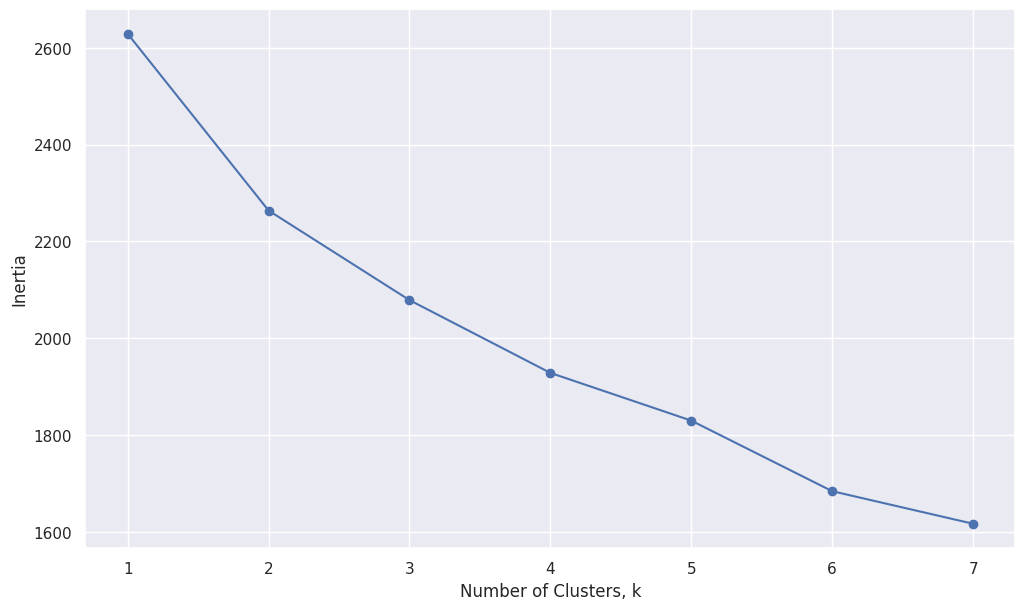

In [15]:
# Plot ks vs inertias
plt.figure(figsize=(12,7))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

### **2.1 Bias measuring**

The fairness of the model can be calculated using the predictions of the model and the protected groups defined previously. The `holisticai` contains a module that calculates a set of metrics useful in evaluating the fairness of algorithmic decisions. For our case, we will use the `clustering_bias_metrics` function which allows us to select which metrics we want to calculate, if `equal_outcome`, `equal_opportunity` or `both`, where equal_outcome shows how disadvantaged groups are treated by the model and equal_opportunity shows if all the groups have the same opportunities.

In [16]:
from holisticai.bias.metrics import clustering_bias_metrics

# we choose to use 3 clusters
model = KMeans(n_clusters = 3, random_state=42)
model.fit(X_t)

# predict
y_pred = model.predict(X_t)

centroids = model.cluster_centers_

df_baseline = clustering_bias_metrics(group_a, group_b, y_pred, data = X_t, centroids = centroids, metric_type = 'equal_outcome')
df_baseline

,Value,Reference
Metric,,
Cluster Balance,4.847870e-22,1
Minimum Cluster Ratio,0.000000e+00,1
Cluster Distribution Total Variation,3.766234e-01,0
Cluster Distribution KL Div,4.880311e-01,0
Social Fairness Ratio,1.055526e+00,1
Silhouette Difference,5.909859e-03,0


1. **Cluster Balance:** Given a clustering and protected attribute. The cluster balance is the minimum over all groups and clusters of the ratio of the representation of members of that group in that cluster to the representation overall. A value of 1 is desired. That is when all clusters have the exact same representation as the data. Lower values imply the existence of clusters where either group_a or group_b is underrepresented.

2. **Minimum Cluster Ratio:** Given a clustering and protected attributes. The min cluster ratio is the minimum over all clusters of the ratio of number of group_a members to the number of group_b members. A value of 1 is desired. That is when all clusters are perfectly balanced. Low values imply the existence of clusters where group_a has fewer members than group_b.

3. **Cluster Distribution Total Variation:** This function computes the distribution of group_a and group_b across clusters. It then outputs the total variation distance between these distributions. A value of 0 is desired. That indicates that both groups are distributed similarly amongst the clusters. The metric ranges between 0 and 1, with higher values indicating the groups are distributed in very different ways.

4. **Cluster Distribution KL Div:** This function computes the distribution of group_a and group_b membership across the clusters. It then returns the KL distance from the distribution of group_a to the distribution of group_b. A value of 0 is desired. That indicates that both groups are distributed similarly amongst the clusters. Higher values indicate the distributions of both groups amongst the clusters differ more.

5. **Social Fairness Ratio:** Given a centroid based clustering, this function compute the average distance to the nearest centroid for both groups. The metric is the ratio of the resulting distance for group_a to group_b. A value of 1 is desired. Lower values indicate the group_a is on average closer to the respective centroids. Higher values indicate that group_a is on average further from the respective centroids.

6. **Silhouette Difference:** We compute the difference of the mean silhouette score for both groups. The silhouette difference ranges from -1 to 1, with lower values indicating bias towards group_a and larger values indicating bias against group_b.


## **3. Train Model with Mitigator**

### **In-processing: Fair K-center Clustering**

The **Fair K-center Clustering** inprocessing bias mitigation implements an approximation algorithm for the k-centers problem under the fairness contraint with running time linear in the size of the dataset and k (number of cluster).

#### **Traditional Implementation**

In [17]:
from holisticai.bias.mitigation import FairKCenterClustering

# set inprocessing model
inprocessing_model = FairKCenterClustering(req_nr_per_group=(1,1), nr_initially_given = 0, seed=1234)

# fit inprocessing model
inprocessing_model.fit(X_t, group_a= group_a, group_b = group_b)

# predict
y_pred = inprocessing_model.predict(X_t)

# set up data arrays
centroids = inprocessing_model.all_centroids

df_fair_kcenter = clustering_bias_metrics(group_a, group_b, y_pred, data = X_t, centroids = centroids, metric_type = 'equal_outcome')
df_fair_kcenter

,Value,Reference
Metric,,
Cluster Balance,0.660490,1
Minimum Cluster Ratio,0.527027,1
Cluster Distribution Total Variation,0.043392,0
Cluster Distribution KL Div,0.019240,0
Social Fairness Ratio,1.111603,1
Silhouette Difference,-0.012350,0


Below we tested different number of clusters to observe the behavior of metrics.

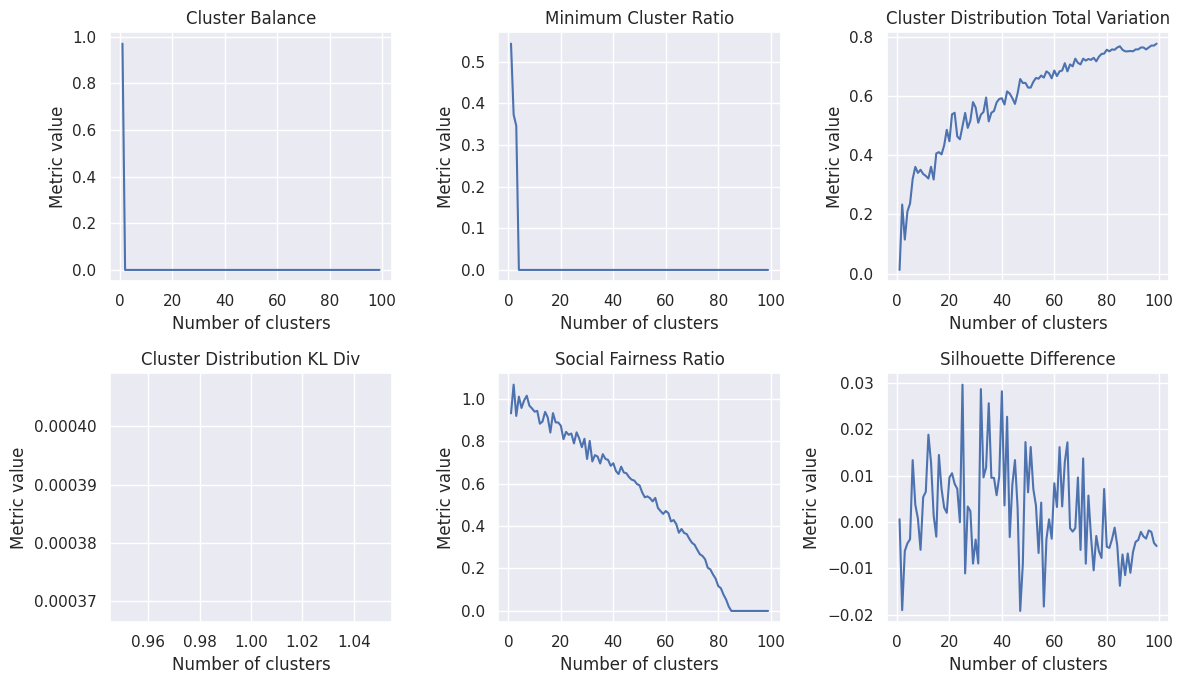

In [18]:
metric_names = ['Cluster Balance', 'Minimum Cluster Ratio', 'Cluster Distribution Total Variation', 'Cluster Distribution KL Div', 'Social Fairness Ratio', 'Silhouette Difference']

metric_values = []
for j in range(1, 100):
    # set inprocessing model
    inprocessing_model_range = FairKCenterClustering(req_nr_per_group=(j,j), nr_initially_given = 0)

    # fit inprocessing model
    inprocessing_model_range.fit(X_t, group_a= group_a, group_b = group_b)

    # predict
    y_pred_range = inprocessing_model_range.predict(X_t)

    # set up data arrays
    centroids_range = inprocessing_model_range.all_centroids

    df_fair_kcenter_range = clustering_bias_metrics(group_a, group_b, y_pred_range, data = X_t, centroids = centroids_range,  metric_type = 'equal_outcome')
    metric_values.append(df_fair_kcenter_range['Value'].T)

df_metrics = pd.DataFrame(np.array(metric_values).flatten().reshape(-1,6), columns=metric_names)

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
for i, metric in enumerate(metric_names):
    row = i // 3
    col = i % 3
    axs[row, col].plot(range(1, 100), df_metrics[metric], '-')
    axs[row, col].set_xlabel('Number of clusters')
    axs[row, col].set_ylabel('Metric value')
    axs[row, col].set_title(metric)

plt.tight_layout()
plt.show()

## **4. Using Pipeline**

Now that we could see how this method is implemented traditionally, let's try implementing it by using the Scikit-learn Pipeline! Notice that we shouldn't have variations in the metrics for the previous implementation.

In [19]:
from holisticai.pipeline import Pipeline

# req_nr_per_grop: this parameter represent the number of cluster in each group
inprocessing_model = FairKCenterClustering(req_nr_per_group=(1,1), nr_initially_given=0, seed=1234)

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('bm_inprocessing', inprocessing_model)])

# select data
X, _, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a, 
    "bm__group_b": group_b
}

pipeline.fit(X, **fit_params)

# predict
y_pred = pipeline.predict(X)

# set up data arrays
centroids = pipeline['bm_inprocessing'].all_centroids
X_t = pipeline['scaler'].transform(X)

df_fair_kcenter_w_p = clustering_bias_metrics(group_a, group_b, y_pred, data = X_t, centroids = centroids, metric_type = 'equal_outcome')
df_fair_kcenter_w_p

,Value,Reference
Metric,,
Cluster Balance,0.660490,1
Minimum Cluster Ratio,0.527027,1
Cluster Distribution Total Variation,0.043392,0
Cluster Distribution KL Div,0.019240,0
Social Fairness Ratio,1.111603,1
Silhouette Difference,-0.012350,0


Below we tested different number of clusters to observe the behavior of metrics. As we can see, the Social Fairness ratio metric moves away from the reference as the number of clusters increases. The same happens with Silhouette Difference, but the metric takes longer to move away from the reference. Thus, the mitigator is effective for a low number of clusters.

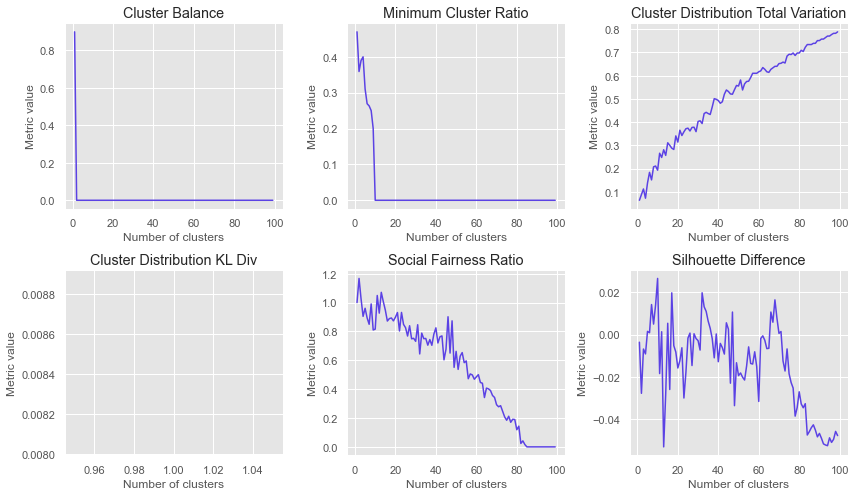

In [53]:
metric_names = ['Cluster Balance', 'Minimum Cluster Ratio', 'Cluster Distribution Total Variation', 'Cluster Distribution KL Div', 'Social Fairness Ratio', 'Silhouette Difference']
num_metrics = len(metric_names)


metric_values = []
for j in range(1, 100):
    inprocessing_model = FairKCenterClustering(req_nr_per_group=(j,j), nr_initially_given=0)

    pipeline = Pipeline(steps=[
        ('bm_inprocessing', inprocessing_model)])

    # select data
    X, _, group_a, group_b = train_data
    fit_params = {
        "bm__group_a": group_a, 
        "bm__group_b": group_b
    }

    pipeline.fit(X, **fit_params)

    # predict
    y_pred = pipeline.predict(X)

    # set up data arrays
    centroids = pipeline['bm_inprocessing'].all_centroids

    df_fair_kcenter_range = clustering_bias_metrics(group_a, group_b, y_pred, data = X, centroids = centroids, metric_type = 'equal_outcome')
    metric_values.append(df_fair_kcenter_range['Value'].T)

df_metrics = pd.DataFrame(np.array(metric_values).flatten().reshape(-1,6), columns=metric_names)

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
for i, metric in enumerate(metric_names):
    row = i // 3
    col = i % 3
    axs[row, col].plot(range(1, 100), df_metrics[metric], '-')
    axs[row, col].set_xlabel('Number of clusters')
    axs[row, col].set_ylabel('Metric value')
    axs[row, col].set_title(metric)

plt.tight_layout()
plt.show()

## **5. Results comparison**

In [20]:
result = pd.concat([df_baseline, df_fair_kcenter, df_fair_kcenter_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Cluster Balance,4.847870e-22,0.660490,0.660490,1
Minimum Cluster Ratio,0.000000e+00,0.527027,0.527027,1
Cluster Distribution Total Variation,3.766234e-01,0.043392,0.043392,0
Cluster Distribution KL Div,4.880311e-01,0.019240,0.019240,0
Social Fairness Ratio,1.055526e+00,1.111603,1.111603,1
Silhouette Difference,5.909859e-03,-0.012350,-0.012350,0


We can observe that use the mitigator is effective to create more fair results.

## **Summary**

Through this tutorial we could present to the user how the `holisticai` library can be easily used to measure the bias present in clustering models by the application of the `clustering_bias_metrics` function, which returns the calculated values for different metrics and their references respectively. 

In addition, we shown how to mitigate the bias by applying some methods, for this opportunity we applied the **Fair-KCenter-Clustering** to train a fairness model, 